Esse script tem como objetivo baixar os arquivos/ planilhas com dados de população carcerária do Brasil, disponíveis em: [https://www.gov.br/depen/pt-br/sisdepen/mais-informacoes/relatorios-infopen](https://www.gov.br/depen/pt-br/sisdepen/mais-informacoes/relatorios-infopen).

O Sistema de Informações do Departamento Penitenciário Nacional (**SISDEPEN**) é a 'plataforma de estatísticas do sistema penitenciário brasileiro que **sintetiza as informações sobre os estabelecimentos penais e a população carcerária**'.

Escolhi pegar esses dados pois tenho o interesse de usar essas informações para um trabalho que teve início da disciplina de Análise Descritiva com as minhas colegas Sara Magalhães e Layane Serrano. Em outras palavras: a coleta desses dados é a tarefa prioritária - a minha grande 'dor' - da semana.

Note que:
Esse site do SISDEPEN tem links (bandeiras) para os arquivos de cada UF:
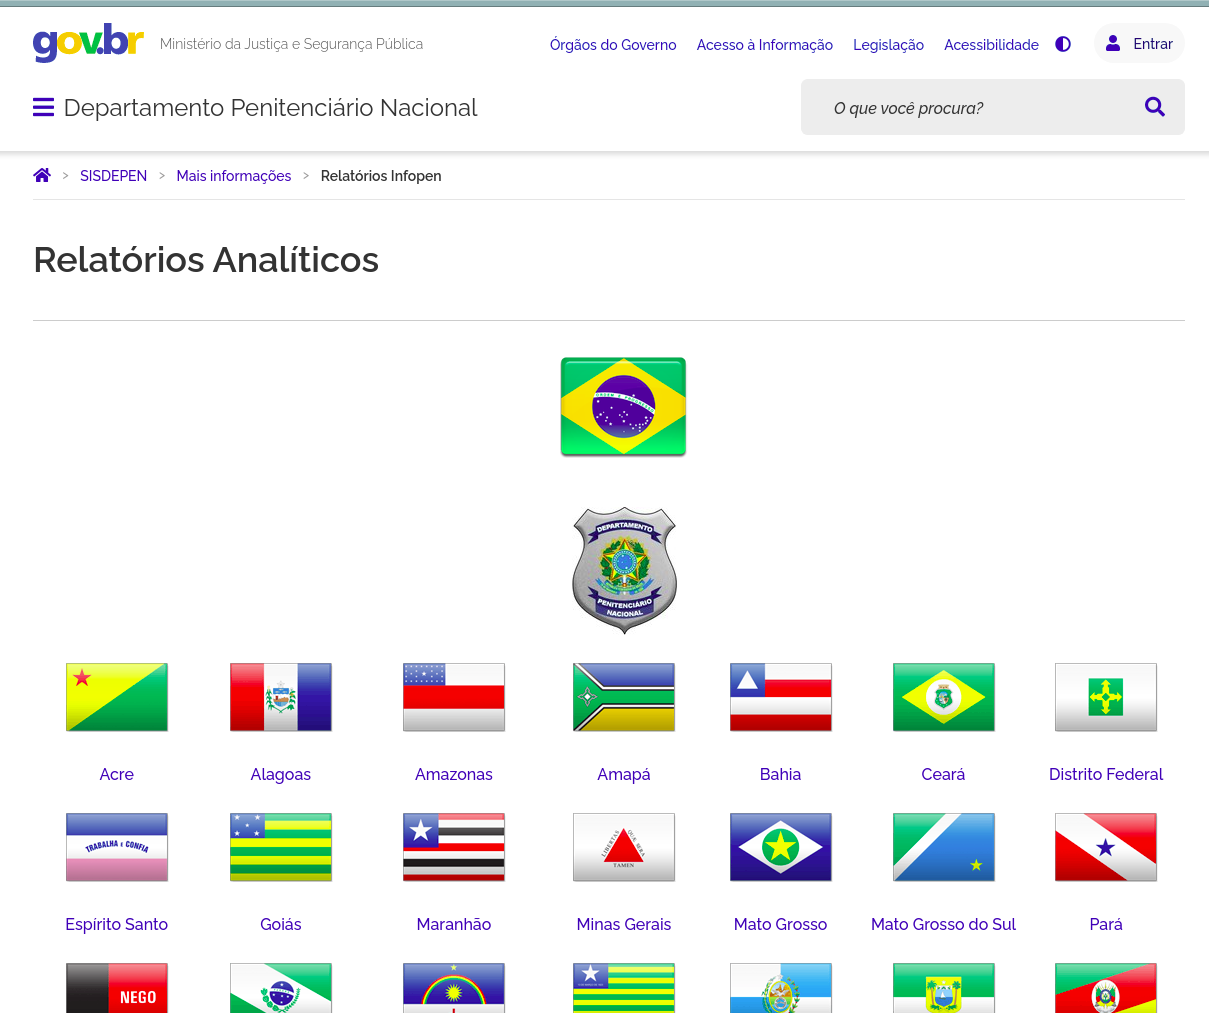


E cada página de UF tem os links de planilhas com os dados por semestre e ano:

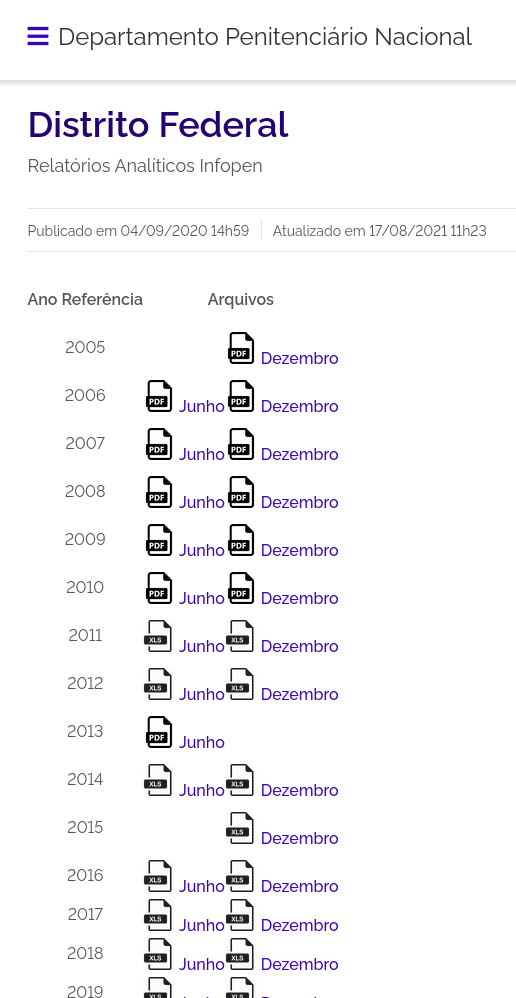

Essas planilhas não estão em segundo plano. 
Elas estão no HTML da página:

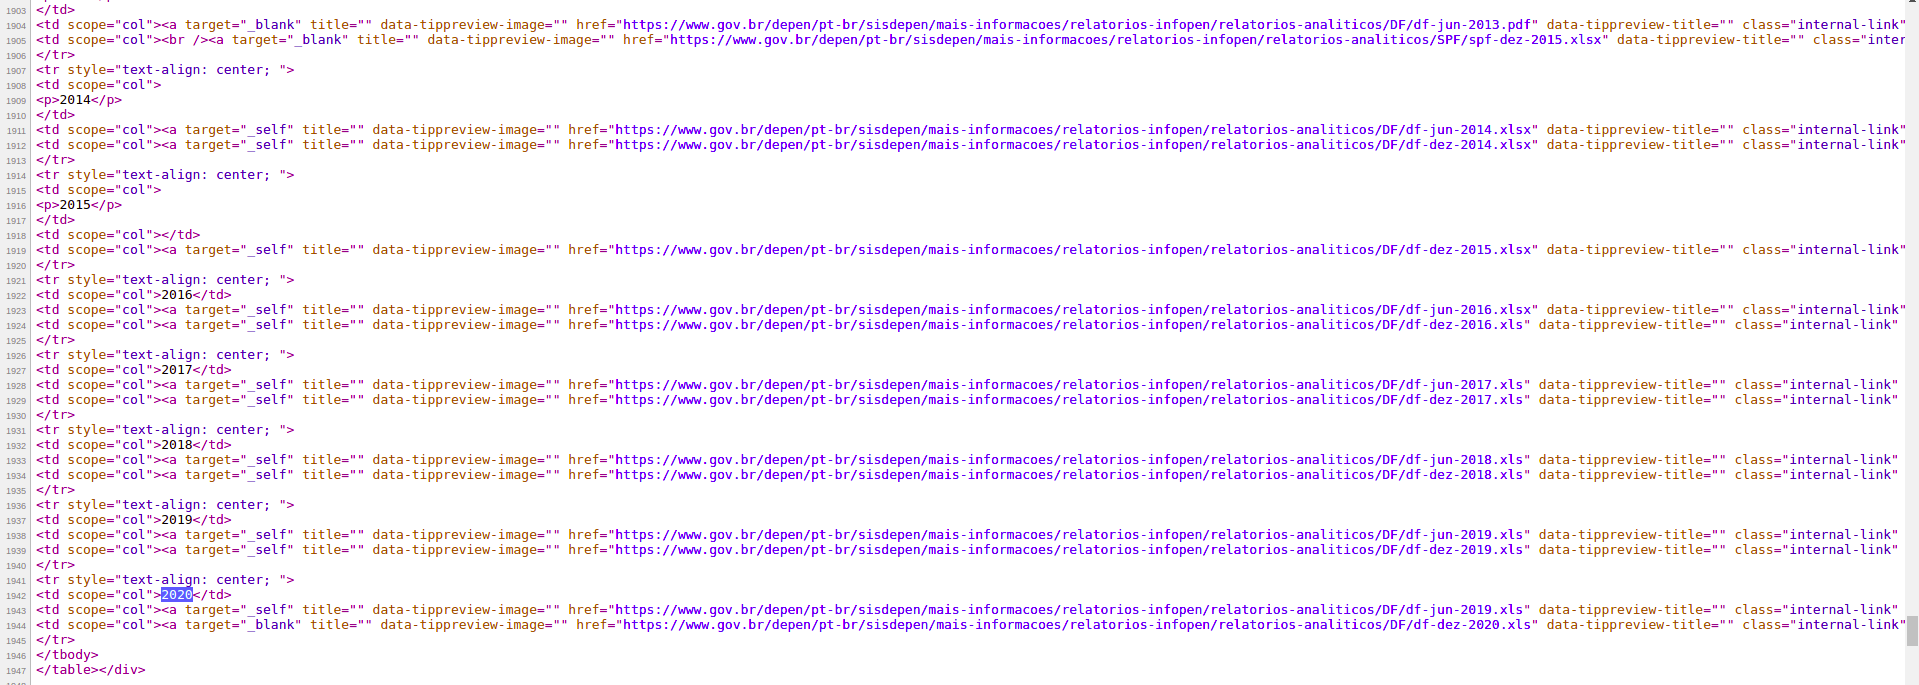

Meu objetivo é: 

1.   Listar todos os links das UFs
2.   Para cada UF: listar todos os arquivos xls ou xlsx disponíveis
3.   Fazer o download de cada um desses arquivos
4.   Comprimir e exportar o conjunto de planilhas para leitura desses dados (no script [leitura_dados](https://colab.research.google.com/drive/1scYg8oT-Qg-z7-7Nowj71VLXIofJMD-C#scrollTo=xX0cc6JghLrd)).

In [ ]:
# Bibliotecas

import requests           # Pegar os links para as planilhas & Baixar as planilhas propriamente ditas
import re                 # Para expressões regulares puteis lendo a pág em HTML
import csv                # Exporto os arquivos com os links em csv
import time               # Guardar o tempo em segundo que demoro p fazer algumas coisas
import os                 # Listar arquivos, criar diretórios
import pandas as pd       # Ler planilhas em xls ou xlsx

# Expressão regular do link
pad_link = re.compile(r'(www|http:|https:)+[^\s]+[\w]') # Peguei do notebook de Exp. Reg.

Criei duas funções, sendo a principal delas (extrai_links) inspirada (inspiradíssima) na função do Álvaro.

In [ ]:
# Função que extrai o link de dentro do HTML
# O esqueleto da função é do Álvaro
def extrai_links(html, pad_link = pad_link):
  links = []
  partes = html.split('<td scope="col"><a target="_self"')

  for parte in partes:
    if 'data-tippreview-image' not in parte:
      continue
    if 'pdf' in parte:
      continue
    subparte = parte.split('data-tippreview-image')
  
    subparte1 = subparte[1]
    string = subparte1.split('data-tippreview-title')[0]  

    # Procurar pelo padrão de link na string
    link_string = re.search(pad_link, string)
    if link_string: 
      link = link_string.group()
      # Os últimos caracteres correspondem a identificadores do arquivo
      ref = link.split("/")[-1]
      uf = re.search('[a-z]{2}', ref).group()
      mes = re.search('[a-z]{3}', ref).group()
      ano = re.search('[0-9]{4}', ref).group()

    # Incrementar a lista de links
    links.append({"uf": uf, "mes": mes, "ano": ano, "link": link})
  return links

In [ ]:
# Função que passa o html específico de cada UF para a função 'extrai_links' e salva em um arq
def extrai_links_por_uf(url, sigla_est):
  pag = url + '/' + sigla_est
  
  resposta = requests.get(pag)
  html = resposta.text

  nome_arq_salvar = 'links/' + sigla_est + '.csv'
  arquivo = open(nome_arq_salvar, mode = "w")
  escritor = csv.DictWriter(arquivo, fieldnames = ["uf", "mes", "ano", "link"])
  escritor.writeheader()

  for link_dict in extrai_links(html):
    escritor.writerow(link_dict)
  arquivo.close()

In [ ]:
# Uma lista com os nomes dos estados como aparece no site sisdepen
# Parece que tem um padrão bem definido mas 'Pernambuco' fugiu do padrão
estados = ['acre', 'alagoas', 'amazonas', 'amapa', 'bahia', 'ceara', 'distrito-federal',
           'espirito-santo', 'goias', 'maranhao', 'minas-gerais', 'mato-grosso', 'mato-grosso-do-sul', 'para',
           'paraiba', 'parana', 'Pernambuco', 'piaui', 'rio-de-janeiro', 'rio-grande-do-norte', 'rio-grande-do-sul',
           'rondonia', 'roraima', 'santa-catarina', 'sao-paulo', 'sergipe', 'tocantins']
#estados

In [ ]:
# Usar a função 'extrai_links_por_uf' para cada diferente pag/UF:
os.mkdir('SISDEPEN_LINKS')

start_links = time.time()

for est in estados:
  extrai_links_por_uf("https://www.gov.br/depen/pt-br/sisdepen/mais-informacoes/relatorios-infopen", est)

stop_links = time.time()

In [ ]:
# Quanto tempo demorou para criar a planilha de links?
print('Start: ', start_links) 
print('Stop: ', stop_links) 
print('Diff time (sec): ', stop_links - start_links )

Start:  1633728445.6450894
Stop:  1633728489.3081152
Diff time (sec):  43.663025856018066


In [ ]:
# Acessar os links salvos nas planilhas e efetivamente baixar esses arquivos
arqs_usar = os.listdir('SISDEPEN_LINKS')
os.mkdir('SISDEPEN_ARQS')

#start = timeit.default_timer()
start_arqs = time.time()

# Iterando em cada planilha com os links
for arq_link in arqs_usar:
  df = pd.read_csv('SISDEPEN_LINKS/' + arq_link)

# Iterando em cada linha da planilha com os links
# Para cada link de dados propriamente ditos
  for file_url in df['link']:
    r = requests.get(file_url, stream = True) 

    nome = "SISDEPEN_ARQS" + "/" + file_url.split("/")[-1]

    with open(nome, "wb") as file: 
      for block in r.iter_content(chunk_size = 1024): 
          if block: 
            file.write(block)

#stop = timeit.default_timer()
stop_arqs = time.time()


# Fonte: https://codingshiksha.com/python/how-to-download-file-from-url-to-google-drive-using-google-colab-in-python-full-project-for-beginners/
#        https://www.youtube.com/watch?v=DdW7sSmuQ8k

In [ ]:
# Quanto tempo demorou?
print('Start: ', start_arqs) 
print('Stop: ', stop_arqs) 
print('Diff time (min): ', (stop_arqs - start_arqs)/60 )

Start:  1633728641.5754416
Stop:  1633729517.209598
Diff time (min):  14.59390260775884


In [ ]:
# Comprimindo os arqs p fazer download
import shutil
shutil.make_archive('SISDEPEN_LINKS', 'zip', 'SISDEPEN_LINKS')
shutil.make_archive('SISDEPEN_ARQS', 'zip', 'SISDEPEN_ARQS')

'/content/arqs_sisdepen.zip'

Dificuldades:

1.   Links das UFs não seguiram padrão (ex.: Pernambuco)
2.   Os dados vem em planilha com estruturas diferentes entre si. É difícil automatizar a leitura dessa informação
3.   Não sou familiarizada com a leitura de arquivos em planilhas e lidar com células mescladas foi um problema.
4.   Na hora de ler os arquivos, duas planilhas quebram o padrão de leitura: 'prjun2020.xls', 'rnjun2020.xls'
5.   Parece que os dados de 2020 estão com as planilhas de 2019. Preciso conferir.

